In [99]:
#General
import numpy
import pandas 
import csv
import re
import nltk
import json
import nltk
from gensim import models
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools

#Análisis de sentimientos
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Clasificador
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


### Función auxiliar que elimina los enlaces incluidos en el tweet y que elimina los tweets que no tengan ningún caracter

In [48]:
def limpiaTweet(df):
    listTweets = df.Tweets.values.tolist()
    pattern = re.compile('https?://(?:[-\w./]|(?:%\da-fA-F{2}))+')
    cleanTweets =[]
    
    for tweet in listTweets:
        res = re.findall(pattern, tweet)
        if (len(res) != 0):
            aux = tweet.replace(res[0], '')
            cleanTweets.append(aux)
        else:
            cleanTweets.append(tweet)
            
    for tweet in cleanTweets:
        if(len(tweet) == 0):
            cleanTweets.remove(tweet)
    
    return numpy.asarray(cleanTweets)

## Actualización del lexicon de vadeSentiment

In [53]:
lexicon = pandas.read_csv('SEL/SEL_UTF8.txt', sep='\t', names=['Palabra', 'PFA', 'Categoría'])
lexicon.drop(['Categoría'], axis='columns', inplace=True)
lexicon.info()

Palabras = numpy.array(lexicon.Palabra)
PFA = numpy.array(lexicon.PFA)

lista = []
for i in range(1, len(Palabras)):
    lista.append([Palabras[i], float(PFA[i])])
    
lexi = {a : b for a,b in lista}
print("\nTotal de palabras del lexicon en español = ", len(lexi))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Palabra  2037 non-null   object
 1   PFA      2037 non-null   object
dtypes: object(2)
memory usage: 32.0+ KB

Total de palabras del lexicon en español =  1909


In [54]:
SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(lexi)

## Clasificador de tópicos (SVM)

In [56]:
stop_words = get_stop_words('spanish')

In [58]:
nombres = ['Titular', 'Tópico']
dataTrain = pandas.read_csv('.//TitularesTrain//titulares.csv', names=nombres)
dataTrain = dataTrain.dropna()
dataTrain.info()

Y = dataTrain.Tópico.values.tolist()
X = dataTrain.Titular.values.tolist()

x_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 0 to 7854
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Titular  3926 non-null   object
 1   Tópico   3926 non-null   object
dtypes: object(2)
memory usage: 92.0+ KB


In [60]:
vectorizer = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), min_df = 3)
X_ = vectorizer.fit_transform(x_train)

print("Dim matriz TF-IDF", X_.shape)
print("Tam y = ", len(y_trainTFIDF))

Dim matriz TF-IDF (3140, 2390)
Tam y =  3140


In [61]:
clfSVM = svm.SVC()
clfSVM.fit(X_, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [63]:
X_TFIDF = vectorizer.transform(X_test)
predSVM = clfSVM.predict(X_TFIDF)
print('accuracy score %0.3f' % clfSVM.score(X_TFIDF, y_test))

accuracy score 0.852


## Prueba de tweets

In [64]:
dataTweets = pandas.read_csv(".//TweetsTest//Tweets//Tweets_UTF8.txt", names=['Tweets'])
dataTweets = dataTweets.dropna()
dataTweets.info()
dataTweets

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3619
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  3620 non-null   object
dtypes: object(1)
memory usage: 56.6+ KB


,Tweets
0,Mensaje importante sobre el Covid-19 hoy lunes...
1,Cada vez que usan la palabra whitexican un idi...
2,#ÚltimaHora México inicia 'nueva normalidad' s...
3,Conferencia de Prensa Covid-19. 1 de junio de ...
4,Mensaje importante de la #4T https://t.co/lRkE...
...,...
3615,Minotaur #symbolism #williamblake https://t.co...
3616,Estoy tan concha escribiendo mi nonsense de la...
3617,El tocayo sufridor... https://t.co/BVQll9KSyb
3618,NO NOS TOQUEN QUE ANDAMOS🔥🔥🔥 \n\n#LaFranjaQueN...


In [65]:
tweets = limpiaTweet(dataTweets)
print(len(tweets))

3370


In [71]:
Covid = []
Tecnologia = []
Deportes = []
Economia =[]
Cultura = []

tweetsTFIDF = vectorizer.transform(tweets)
print(tweetsTFIDF.shape)

predTweetsTopic = clfSVM.predict(tweetsTFIDF)

for i in range(len(predTweetsTopic)):
    if predTweetsTopic[i] == 'covid':
        Covid.append([tweets[i], predTweetsTopic[i]])
        
    elif predTweetsTopic[i] == 'tecnologia':
        Tecnologia.append([tweets[i], predTweetsTopic[i]])
        
    elif predTweetsTopic[i] == 'deportes':
        Deportes.append([tweets[i], predTweetsTopic[i]])
    
    elif predTweetsTopic[i] == 'economia':
        Economia.append([tweets[i], predTweetsTopic[i]])
        
    elif predTweetsTopic[i] == 'cultura':
        Cultura.append([tweets[i], predTweetsTopic[i]])

(3370, 2390)


In [72]:
print("Covid = ", len(Covid))
print("Tecnología = ", len(Tecnologia))
print("Deportes = ", len(Deportes))
print("Economía = ", len(Economia))
print("Cultura = ", len(Cultura))

Covid =  887
Tecnología =  56
Deportes =  788
Economía =  467
Cultura =  1172


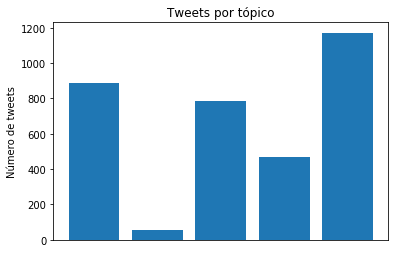

In [94]:
names = ['Covid', 'Tecnología', 'Deportes', 'Economía', 'Cultura']
values = [len(Covid), len(Tecnologia), len(Deportes), len(Economia), len(Cultura)]


plt.bar(names, values)
plt.show()

In [85]:
def polaridadTweetsTopic(listaTweets):
    Pos, Neg, Neu = 0,0,0
    for i in range(len(listaTweets)):
        tweet = listaTweets[i][0]
        vs = SIA.polarity_scores(tweet)
        auxArr = numpy.split(numpy.asarray(list(vs.items())).T, 2)
        values = numpy.asarray(auxArr[1], dtype =float).flatten()
        compound = values[3]

        if(compound >= 0.05):
            Pos += 1
        if(compound <= -0.05):
            Neg += 1
        if (compound > -0.05 and compound < 0.05):
            Neu += 1
            
    return [Pos, Neg, Neu]

In [105]:
resCovid = polaridadTweetsTopic(Covid)
print(resCovid)

[239, 155, 493]


In [106]:
resTecn = polaridadTweetsTopic(Tecnologia)
print(resTecn)

[13, 6, 37]


In [107]:
resDep = polaridadTweetsTopic(Deportes)
print(resDep)

[210, 163, 415]


In [108]:
resEcon = polaridadTweetsTopic(Economia)
print(resEcon)

[154, 91, 222]


In [109]:
resCult = polaridadTweetsTopic(Cultura)
print(resCult)

[317, 173, 682]


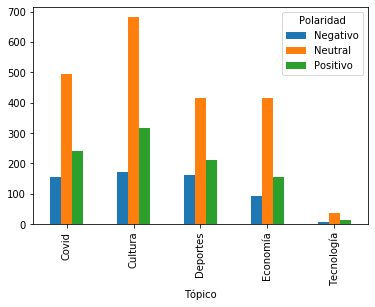

In [122]:
df = pandas.DataFrame([['Positivo','Covid',resCovid[0]],['Negativo','Covid',resCovid[1]],['Neutral','Covid',resCovid[2]],
                   ['Positivo','Tecnología',resTecn[0]],['Negativo','Tecnología',resTecn[1]],['Neutral','Tecnología',resTecn[2]],
                   ['Positivo','Deportes',resDep[0]],['Negativo','Deportes',resDep[1]],['Neutral','Deportes',resDep[2]],
                   ['Positivo','Economía',resEcon[0]],['Negativo','Economía',resEcon[1]],['Neutral','Economía',resDep[2]],
                   ['Positivo','Cultura',resCult[0]],['Negativo','Cultura',resCult[1]],['Neutral','Cultura',resCult[2]]],
                  columns=['Polaridad','Tópico','val'])


df.pivot("Tópico", "Polaridad", "val").plot(kind='bar')
plt.show()